In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw06.ipynb")

# Homework 6: Modeling and Analyzing COVID-19 Cases
## Probability and Estimators
## Due Date: Thursday, March 31, 11:59 PM PDT


**Content Warning**

This assignment includes an analysis of daily COVID-19 cases by U.S. county through 2021. If you feel uncomfortable with this topic, **please contact your GSI or the instructors.**

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** below.

**Collaborators**: *list collaborators here*



## Introduction

In this homework, we will investigate a dataset that contains information about COVID-19 cases in the United States, vaccination rates, and various other metadata that can assist in modeling various aspects of COVID-19.

Through this homework assignment, you will demonstrate your experience with:
* Bootstrap sampling
* Bias-variance tradeoff and decomposition
* Biased and unbiased estimators
* Multicollinearity in features

In [2]:
# Run this cell to set up your notebook
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown

import scipy.stats

<br/><br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 1: Random Variables

Question 1 is a written problem and should be submitted as a separate PDF to the Written portal of Gradescope. All other questions in this assignment are submitted as part of this notebook.

Question 1 PDF File: https://ds100.org/sp22/hw/hw06/hw06_student.pdf
<br>Question 1 Overleaf Template: https://ds100.org/sp22/hw/hw06/hw06_template.zip

<br/><br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 2: Exploratory Data Analysis

Let's perform some initial exploratory data analysis to examine and visualize potential trends in a COVID-19 dataset.

In [3]:
# just run this cell
covid_data = pd.read_csv('data/covid_data.csv')
covid_data.head(5)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE042020,POPESTIMATE2020,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,84001001,US,USA,840,1001,Autauga,Alabama,US,32.539527,-86.644082,...,55533,55769,56130,56145,1001,0.053,0.074,0.134,0.295,0.444
1,84001003,US,USA,840,1003,Baldwin,Alabama,US,30.727750,-87.722071,...,218071,223565,227989,229287,1003,0.083,0.059,0.098,0.323,0.436
2,84001005,US,USA,840,1005,Barbour,Alabama,US,31.868263,-85.387129,...,24887,24657,24652,24589,1005,0.067,0.121,0.120,0.201,0.491
3,84001007,US,USA,840,1007,Bibb,Alabama,US,32.996421,-87.125115,...,22300,22313,22199,22136,1007,0.020,0.034,0.096,0.278,0.572
4,84001009,US,USA,840,1009,Blount,Alabama,US,33.982109,-86.567906,...,57770,57840,57932,57879,1009,0.053,0.114,0.180,0.194,0.459


The data are at county granularity; each row corresponds to COVID-19 data from a U.S. county. Here are some highlights and data sources:

* The first few columns encode county and state data; for example, check out the [FIPS](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) numeric encoding for U.S. counties.
* The next 600 columns record daily COVID-19 cases in the county for the date range 1/22/2020 to 9/12/2021. COVID-19 case data are from CSSE at Johns Hopkins University [GitHub](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv).
* The next few columns include county populations from [U.S. census data](https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020.csv), the latest of which is 2020.
* The last 5 columns record mask usage survey data on a 5-point scale from `NEVER` to `ALWAYS`. Data are collected in July 2020 from the New York Times [GitHub](https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv).

We can use `covid_data.describe()` to see various statistics about the numerical features of the provided COVID-19 data. Do any particular statistics stand out to you? Which might be useful when modeling?

**Note:** This isn't a question (i.e. it's worth no points); this is just food for thought as you start to explore the dataset.

In [4]:
# just run this cell
covid_data.describe()

,UID,code3,FIPS,Lat,Long_,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE042020,POPESTIMATE2020,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
count,3.141000e+03,3141.0,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,...,3.141000e+03,3.141000e+03,3.141000e+03,3.141000e+03,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000
mean,8.403039e+07,840.0,30392.602674,38.448156,-92.272006,0.000318,0.000318,0.000637,0.000637,0.001592,...,1.040525e+05,1.045274e+05,1.048677e+05,1.048949e+05,30392.602674,0.079952,0.082929,0.121340,0.207728,0.508044
std,1.515661e+04,0.0,15156.613190,5.292540,12.909318,0.017843,0.017843,0.025230,0.025230,0.039873,...,3.326200e+05,3.332156e+05,3.335848e+05,3.333719e+05,15156.613190,0.058543,0.055469,0.058007,0.063581,0.152190
min,8.400100e+07,840.0,1001.000000,19.601212,-174.159600,0.000000,0.000000,0.000000,0.000000,0.000000,...,8.700000e+01,8.700000e+01,9.000000e+01,8.700000e+01,1001.000000,0.000000,0.000000,0.001000,0.029000,0.115000
25%,8.401818e+07,840.0,18179.000000,34.693167,-98.218207,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.096300e+04,1.093600e+04,1.091900e+04,1.092100e+04,18179.000000,0.034000,0.040000,0.079000,0.164000,0.393000
50%,8.402918e+07,840.0,29177.000000,38.373019,-90.396561,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.583700e+04,2.573500e+04,2.570100e+04,2.565800e+04,29177.000000,0.068000,0.073000,0.115000,0.204000,0.497000
75%,8.404508e+07,840.0,45081.000000,41.802830,-83.436796,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.813600e+04,6.828200e+04,6.822000e+04,6.824100e+04,45081.000000,0.113000,0.115000,0.156000,0.247000,0.613000
max,8.405604e+07,840.0,56045.000000,69.314792,-67.628135,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.006153e+07,1.001160e+07,9.968969e+06,9.943046e+06,56045.000000,0.432000,0.384000,0.422000,0.549000,0.889000


### Question 2a

In this homework, we will use linear regression to predict the number of COVID-19 cases on September 12th, 2021 using linear regression. **per capita** (i.e. the number of COVID-19 cases in a county divided the population of the county). Define a column `'9/12/2021_cpc'` in `covid_data` corresponding to the number of cases per capita on September 12th, 2021. 

Note that we will **always** use the `'POPESTIMATE2020'` as the population of each county.

*Hint*: The number of cases per capita should be the total number of cases in a county divided by the population of the county.

<!--
BEGIN QUESTION
name: q2a
points: 3
-->

In [6]:
covid_data['9/12/2021_cpc'] = covid_data['9/12/21'] / covid_data['POPESTIMATE2020']

In [7]:
grader.check("q2a")

q2a results: All test cases passed!

### Question 2b

Assign `mask_data` that has six columns from the original `covid_data` table: the five mask columns and the `9/12/2021_cpc` column.

**Note**: You should make a **copy** of these columns using `df.copy()` ([link](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html)).


<!--
BEGIN QUESTION
name: q2b
points: 1
-->

In [14]:
mask_data

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,POPESTIMATE2019,POPESTIMATE042020,POPESTIMATE2020,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,9/12/2021_cpc
0,84001001,US,USA,840,1001,Autauga,Alabama,US,32.539527,-86.644082,...,55769,56130,56145,1001,0.053,0.074,0.134,0.295,0.444,0.165411
1,84001003,US,USA,840,1003,Baldwin,Alabama,US,30.727750,-87.722071,...,223565,227989,229287,1003,0.083,0.059,0.098,0.323,0.436,0.152429
2,84001005,US,USA,840,1005,Barbour,Alabama,US,31.868263,-85.387129,...,24657,24652,24589,1005,0.067,0.121,0.120,0.201,0.491,0.134003
3,84001007,US,USA,840,1007,Bibb,Alabama,US,32.996421,-87.125115,...,22313,22199,22136,1007,0.020,0.034,0.096,0.278,0.572,0.171440
4,84001009,US,USA,840,1009,Blount,Alabama,US,33.982109,-86.567906,...,57840,57932,57879,1009,0.053,0.114,0.180,0.194,0.459,0.158538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,84056037,US,USA,840,56037,Sweetwater,Wyoming,US,41.659439,-108.882788,...,42917,42717,42673,56037,0.061,0.295,0.230,0.146,0.268,0.143205
3137,84056039,US,USA,840,56039,Teton,Wyoming,US,43.935225,-110.589080,...,23385,23453,23497,56039,0.095,0.157,0.160,0.247,0.340,0.196238
3138,84056041,US,USA,840,56041,Uinta,Wyoming,US,41.287818,-110.547578,...,20196,20169,20215,56041,0.098,0.278,0.154,0.207,0.264,0.158496
3139,84056043,US,USA,840,56043,Washakie,Wyoming,US,43.904516,-107.680187,...,7824,7756,7760,56043,0.204,0.155,0.069,0.285,0.287,0.144330


In [36]:
mask_data = covid_data.iloc[:,:-7:-1].copy()
mask_data

,9/12/2021_cpc,ALWAYS,FREQUENTLY,SOMETIMES,RARELY,NEVER
0,0.165411,0.444,0.295,0.134,0.074,0.053
1,0.152429,0.436,0.323,0.098,0.059,0.083
2,0.134003,0.491,0.201,0.120,0.121,0.067
3,0.171440,0.572,0.278,0.096,0.034,0.020
4,0.158538,0.459,0.194,0.180,0.114,0.053
...,...,...,...,...,...,...
3136,0.143205,0.268,0.146,0.230,0.295,0.061
3137,0.196238,0.340,0.247,0.160,0.157,0.095
3138,0.158496,0.264,0.207,0.154,0.278,0.098
3139,0.144330,0.287,0.285,0.069,0.155,0.204


In [37]:
grader.check("q2b")

q2b results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 2c

In our first model, we will use county-wise mask usage data to predict the number of COVID-19 cases on September 12th, 2021 (i.e., the column `9/12/2021_cpc`). Create a visualization that shows the pairwise correlation between each combination of columns in `mask_data`. For 2-D visualizations, consider Seaborn's [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

*Hint*: You should be plotting 36 values corresponding to the pairwise correlations of the six columns in `mask_data`.

<!--
BEGIN QUESTION
name: q2c
points: 3
manual: True
-->

<AxesSubplot:>

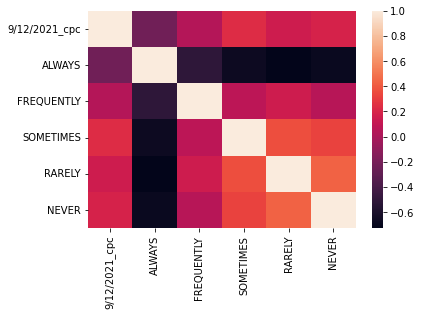

In [59]:
sns.heatmap(mask_data.corr())

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2d

(1) Describe the trends and takeaways visible in the visualization of pairwise correlations you plotted in Question 2c.

(2) Consider the following linear regression model
$$\hat{y} = \theta^T x,$$
where $\hat{y}$ is the predicted number of COVID-19 cases per capita on 9/12/2021 and $x$ is the five mask usage features. Comment on the quality of predictions and interpretability of features if we fit this linear model to the data.

<!--
BEGIN QUESTION
name: q2d
points: 3
manual: True
-->

1. cases per cap are strongly correlation never rarely no mask and negative with always wear mask
2. mask feature affect the cases

<!-- END QUESTION -->



<br/><br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 3: Creating a Preliminary COVID-19 Model

This question will guide you through creating a supervised learning framework that will predict the number of COVID-19 cases per capita given various COVID-19 safety protocols that have been implemented. Then, we will investigate the bias, variance, and observational noise of this framework in the next question.

Note that any answer responses without the appropriate work (i.e. code or explanation) will be subject to additional review and will not receive any credit.

### Question 3a

Train a linear regression model using Scikit-learn, with an intercept term to predict the number of COVID-19 cases per capita for September 12, 2021 using county-wise mask usage data from `mask_data`. Use `train_test_split` to evaluate your model's RMSE on a held-out test set with 33% of the COVID-19 data; call the resulting splits `X_train`, `X_test`, `y_train`, and `y_test`.

To pass the autograder, make sure to set the parameter `random_state` to 42 in your call to `train_test_split` to generate a reproducible data split ([documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)).


<!--
BEGIN QUESTION
name: q3a
points: 5
-->

In [69]:
from sklearn.metrics import mean_squared_error
# Create train/test sets
X = mask_data.iloc[:,1:]
y = mask_data.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# fit the linear model and make predictions
model = lm.LinearRegression().fit(X_train,y_train)

# compute RMSE on train and test sets
train_rmse_cpc = mean_squared_error(model.predict(X_train), y_train,squared=False)
test_rmse_cpc = mean_squared_error(model.predict(X_test), y_test,squared=False)

# ...

train_rmse_cpc, test_rmse_cpc

(0.03552339478226883, 0.037954861477287)

In [70]:
grader.check("q3a")

q3a results: All test cases passed!

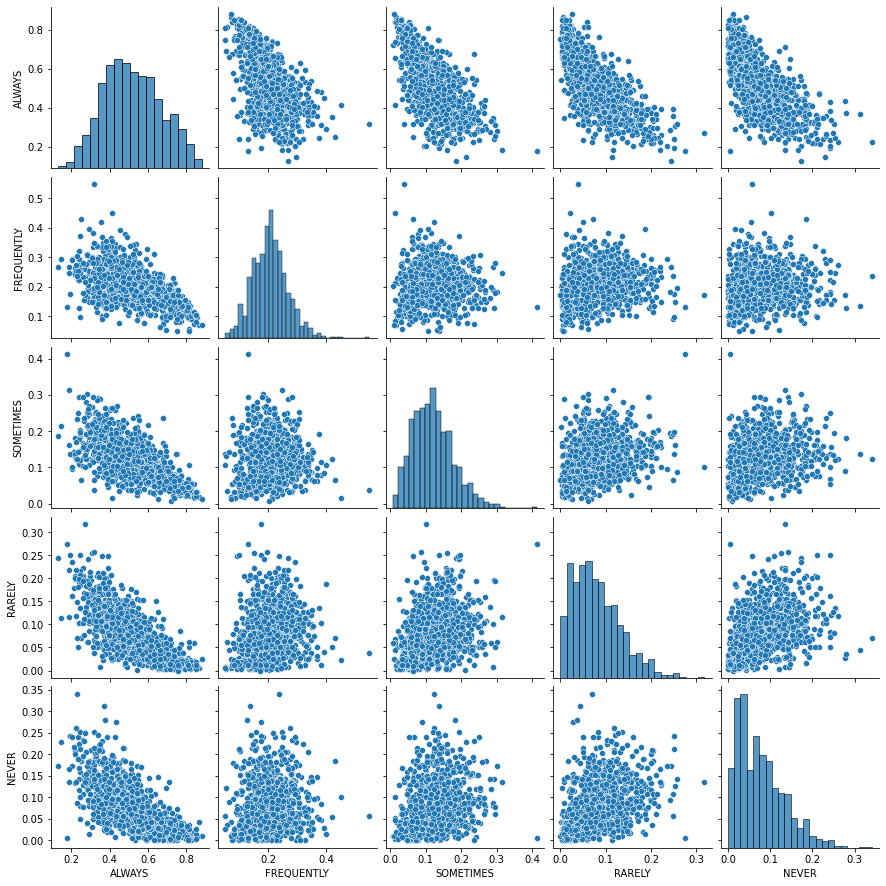

In [141]:
sns.pairplot(X_test)

<!-- BEGIN QUESTION -->

### Question 3b

Visualize the model performance from part (a) by plotting two visualizations: (1) the predictions vs observations on the test set and (2) the residuals for the test set.

Some notes:
* We've used `plt.subplot` ([documentation](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html)) so that you can view both visualizations side-by-side. For example, `plt.subplot(121)` sets the plottable area to the first column of a 1x2 plot grid; you can then call Matplotlib and Seaborn functions to plot that area, before the next `plt.subplot(122)` area is set.
* Remember to add a guiding line to both plot where $\hat{y} = y$, i.e., where the residual is 0.
* Remember to label your axes.

<!--
BEGIN QUESTION
name: q3b
points: 3
manual: True
-->

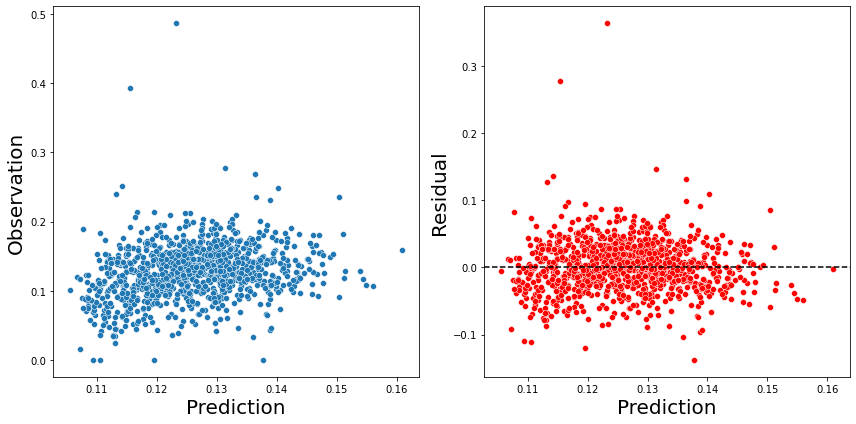

In [159]:
pred, obs =model.predict(X_test), y_test

plt.figure(figsize=(12,6))      # do not change this line

plt.subplot(121)                # do not change this line
# (1) predictions vs observations
p1 = sns.scatterplot(x=pred, y = obs )
p1.set_xlabel("Prediction", fontsize = 20)
p1.set_ylabel("Observation", fontsize = 20)

plt.subplot(122)               # do not change this line
# (2) residual plot
p2 = sns.scatterplot(x=pred , y= obs - pred,color='r')
p2.set_xlabel("Prediction", fontsize = 20)
p2.set_ylabel("Residual", fontsize = 20)
plt.axhline(y=0, color="black", linestyle="--")

plt.tight_layout()             # do not change this line

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3c

Describe what the plots in part (b) indicates about this linear model. Justify your answer.

<!--
BEGIN QUESTION
name: q3c
points: 3
manual: True
-->

independent variables in the regression model are highly correlated to each other

<!-- END QUESTION -->



<br/><br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 4: Performing Multicollinearity Analysis

This question will guide you through performing an analysis that can reveal potential multicollinearity in our features, which is unideal.

Note that any answer responses without the appropriate work (i.e. code or math) will be subject to additional review and will not receive any credit.

### Question 4a

Fill in the blanks below to implement the `bootstrap_sample` function, that returns $k$ randomly drawn samples from a dataset $\mathcal{D}$ of size $n$ with replacement, each of size $n$ (i.e. same size as the dataset). In other words, the returned object should be a Python list `samples` containing $k$ Pandas DataFrames, each of which have $n$ rows.

*Hint*: Take a look at the [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) for `df.sample`!

<!--
BEGIN QUESTION
name: q4a
points: 5
-->

In [207]:
def bootstrap_sample(data, k):
    """
    Performs bootstrap sampling on data to obtain k samples of size n.
    
    Arguments:
        data - Dataset contained as a Pandas DataFrame 
        k - Number of randomly drawn samples
    
    Returns:
        samples - List containing k Pandas DataFrames of size n each
                  corresponding to each sample  
    """
    samples = []
    for i in range(k):
        s = data.sample(data.shape[0],replace=True)
        samples.append(s)
    return samples

# ...
bootstrap_sample(mask_data, 1)[0]

,9/12/2021_cpc,ALWAYS,FREQUENTLY,SOMETIMES,RARELY,NEVER
781,0.132170,0.492,0.223,0.092,0.115,0.079
2723,0.079280,0.596,0.150,0.103,0.046,0.105
2902,0.080049,0.708,0.170,0.079,0.035,0.008
1112,0.159647,0.362,0.265,0.138,0.111,0.122
2942,0.098143,0.678,0.202,0.062,0.041,0.017
...,...,...,...,...,...,...
2816,0.044713,0.604,0.050,0.104,0.190,0.051
123,0.135656,0.383,0.250,0.054,0.072,0.241
243,0.130822,0.685,0.185,0.071,0.027,0.032
2801,0.153796,0.588,0.254,0.056,0.063,0.039


In [208]:
grader.check("q4a")

q4a results: All test cases passed!

### Question 4b

Using the function from the previous part, generate 1000 bootstrapped samples from the original `mask_data` dataframe. Use Scikit-learn to fit a linear regression model of mask features (with an intercept term) to predict the `9/12/2021_cpc` response. You should fit your model to **each** of the 1000 datasets such that we have 1000 trained models. Make sure to store each of the 1000 trained models in the Python list `models`.

Note: You *should not* create any validation or testing sets in this subpart; you should fit your model to the entire resampled dataframe.

<!--
BEGIN QUESTION
name: q4b
points: 5
-->

In [209]:
np.random.seed(42)

datasets = bootstrap_sample(mask_data, 1000)
models = []
for d in datasets:
    X , y = d.iloc[:,1:], d.iloc[:,0]
    model = lm.LinearRegression().fit(X, y)
    models.append(model)

# ...

# These take up a lot of memory, so we should remove them!
del datasets

In [210]:
grader.check("q4b")

q4b results: All test cases passed!

### Question 4c

Fill in the blanks below in the `confidence_interval` function to generate a 95% confidence interval for each of our parameters $\theta_i$, including an intercept term if applicable. All of the helper code to extract coefficients from our trained models has been implemented for you already.

<!--
BEGIN QUESTION
name: q4c
points: 2
-->

In [215]:
def extract_coefs(models, include_intercept = True):
    """
    NOTE: This function has already been implemented. You do not need to modify this!
    
    Extracts coefficients of all the linear regression models in models, and returns
    it as a NumPy array with one model's coefficients as each row.
    
    Arguments:
        models - Contains k sklearn LinearRegression models, each with p + 1 coefficients
        include_intercept - Whether to include intercept in returned coefficients
    
    Returns:
        coef_array - Coefficients of all k models, each with p + 1 coefficients (if intercept
                     enabled, otherwise p). Returned object is k x (p + 1) NumPy array.
    """
    coef_array = np.zeros(shape = (len(models), len(models[0].coef_) + 1))
    for i, m in enumerate(models):
        coef_array[i, 0] = m.intercept_
        coef_array[i, 1:] = m.coef_
    if include_intercept:
        return coef_array 
    return coef_array[:, 1:]

def confidence_interval(coefs):
    """
    Calculates confidence intervals for each theta_i based on coefficients of 
    bootstrapped models. Returns output as a list of confidence intervals.
    
    Arguments:
        coefs - Output of extract_coefs, a k x (p + 1) or k x p NumPy array containing
                coefficients of bootstrapped models
    
    Returns:
        cis - Confidence intervals of each parameter theta_i in the form of a 
              list like this: [(0.5, 0.75), (0.2, 0.4), ...]
    """
    cis = []
    
    # FILL IN CODE BELOW
    for i in range(coefs.shape[1]):
        theta_i_values = coefs[:,i]
        theta_i_lower_ci, theta_i_upper_ci = np.percentile(theta_i_values,2.5), np.percentile(theta_i_values,97.5)
        cis.append((theta_i_lower_ci, theta_i_upper_ci))
    
    return cis

# ...

# compute confidence intervals
model_coefs = extract_coefs(models)
cis = confidence_interval(model_coefs)

# pretty print in a table
display(Markdown('#### Confidence Intervals:'))
md_list = ["|parameter|lower|upper|",
           "----|----|----|"]
md_list += [fr"|$\theta_{i}$|{lci}|{uci}|" for i, (lci, uci) in enumerate(cis)]
display(Markdown('\n'.join(md_list)))

#### Confidence Intervals:

|parameter|lower|upper|
----|----|----|
|$\theta_0$|-2.620072672904502|1.2507871842264515|
|$\theta_1$|-1.1477854499080087|2.7195109052025535|
|$\theta_2$|-1.1582158941594138|2.7329392573407807|
|$\theta_3$|-1.0182943692217794|2.8436420433760565|
|$\theta_4$|-1.146133154081564|2.7445190254359324|
|$\theta_5$|-1.0896828874130355|2.798332585238003|

In [216]:
grader.check("q4c")

q4c results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 4d

Interpret the confidence intervals above for each of the $\theta_i$, where $\theta_0$ is the intercept term and the remaining $\theta_i$ for $i > 0$ are parameters corresponding to mask usage features. What does this indicate about our data and our model?

Describe a mathematical reason why this could be happening.

*Hint*: Take a look at the design matrix!

<!--
BEGIN QUESTION
name: q4d
points: 3
manual: True
-->

There are 95% confidence that True theta could be zero for those parameters according to random distribution..

<!-- END QUESTION -->



<br/><br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 5: Performing Bias-Variance Analysis

This question will guide you through performing an analysis that can estimate the bias and variance of our models, which can be helpful in modeling.

Note that any answer responses without the appropriate work (i.e. code or explanation) will be subject to additional review and will not receive any credit.

### Question 5a

We will use the same bootstrapped models contained in the Python list `models` to estimate our **model variance**. To do this, recall that the model variance on a data point is simply the variance of our predictions on that sample point. From the bias-variance decomposition in lecture, for a parametric model $\hat{Y}(x) = f_{\hat{\theta}}(x)$:

$$\text{model variance} = \mathrm{Var}(f_{\hat{\theta}}(x))$$

To investigate the variance in our test predictions, we sample a particular data point $(x_i, y_i)$. Define the **model risk** for this point as the mean square error over all possible fitted models:

$$\mathbb{E}\left[\left(y_i - f_{\hat{\theta}}(x_i)\right)^2\right]$$

Note that in contrast to lecture, you are considering a particular observation of the random response variable $Y = y_i$. Therefore model risk is an expectation over the estimate $\hat{\theta}$, which is a function of the random sample you used to fit your model.

Using the bootstrapped estimates `models`, approximate the ratio of model variance to model risk for the datapoint $i = 100$, i.e., $(x_{100}, y_{100})$. You can interpret this ratio as the the proportion of the expected square error on the data point "captured" by the model variance. Since you bootstrapped 1000 models, you can generate 1000 predictions for the given $x_i$. Recall that `X` is the design matrix of mask features, and `y` is the `9/12/2021_cpc` response.

Assign `prop_var` to the computed, approximate ratio:

$$
\frac{\mathrm{Var}\left(f_{\hat{\theta}}(x_{100})\right)}{\mathbb{E}\left[\left(y_{100} - f_{\hat{\theta}}(x_{100})\right)^2\right]}
$$
<!--
BEGIN QUESTION
name: q5a
points: 3
-->

In [287]:
x100,y100 = mask_data.iloc[100:101,1:], mask_data.iloc[100,0]

y_hats = np.array([m.predict(x100) for m in models])
prop_var = np.var(y_hats) / np.mean(np.square(y100 - y_hats))

prop_var

0.0013169176499108963

In [288]:
grader.check("q5a")

q5a results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5b

Comment on the ratio `prop_var`, which is the proportion of the expected square error on the data point captured by the model variance. Is the model variance the dominant term in the bias-variance decomposition? If not, what term(s) dominate the bias-variance decomposition?

Justify your answer.

<!--
BEGIN QUESTION
name: q5b
points: 3
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

### Question 5c

Using the bias-variance decomposition above, calculate the average variance and average mean square error across 250 randomly sampled $(x_i, y_i)$ points. In other words, estimate the following quantities across all $x_i$ and $y_i$ in `X_sample` and `y_sample`:

$$
\frac{1}{250} \sum_{i=1}^{250} \mathrm{Var}\left(f_{\hat{\theta}}(x_i)\right)
$$

and

$$
\frac{1}{250} \sum_{i=1}^{250} \mathbb{E}\left[\left(y_i - f_{\hat{\theta}}(x_i)\right)^2\right]
$$

<!--
BEGIN QUESTION
name: q5c
points: 3
manual: False
-->

In [296]:
np.random.seed(42)

X_sample = X.sample(250)         # generate 250 x_i
y_sample = y.loc[X_sample.index] # ...and select the corresponding y_i

avg_var, avg_mse = np.mean(np.var(model.predict(X_sample))), np.mean(np.square( y_sample - model.predict(X_sample)))
# # ...
avg_var, avg_mse

ValueError: operands could not be broadcast together with shapes (533,) (250,) 

In [298]:
X_sample.shape

(250, 5)

In [ ]:
grader.check("q5c")

<!-- BEGIN QUESTION -->

### Question 5d

Propose a solution to reducing the mean square error using the insights gained from the bias-variance decomposition above. Please show all quantities and work that informs your analysis.

Assume that the standard bias-variance decomposition used in lecture can be applied here.
<!--
BEGIN QUESTION
name: q5d
points: 2
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



<br/><br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 6: Improving our Model



### Question 6a

Suppose we decide to add a feature to our model corresponding to the number of cases per capita the week before (i.e. September 5, 2021). Calculate the cases per capita on September 5, 2021 from the original `covid_data` table, and store it in `mask_data` as a column named `'9/5/2021_cpc'`.

*Hint*: This should be similar to Question 2a!

<!--
BEGIN QUESTION
name: q6a
points: 1
-->

In [299]:
mask_data['9/5/2021_cpc'] =  covid_data['9/5/21'] / covid_data['POPESTIMATE2020']
mask_data

,9/12/2021_cpc,ALWAYS,FREQUENTLY,SOMETIMES,RARELY,NEVER,9/5/2021_cpc
0,0.165411,0.444,0.295,0.134,0.074,0.053,0.160513
1,0.152429,0.436,0.323,0.098,0.059,0.083,0.148561
2,0.134003,0.491,0.201,0.120,0.121,0.067,0.129489
3,0.171440,0.572,0.278,0.096,0.034,0.020,0.163896
4,0.158538,0.459,0.194,0.180,0.114,0.053,0.153113
...,...,...,...,...,...,...,...
3136,0.143205,0.268,0.146,0.230,0.295,0.061,0.135706
3137,0.196238,0.340,0.247,0.160,0.157,0.095,0.191599
3138,0.158496,0.264,0.207,0.154,0.278,0.098,0.151026
3139,0.144330,0.287,0.285,0.069,0.155,0.204,0.139175


In [300]:
grader.check("q6a")

q6a results: All test cases passed!

### Question 6b

Add the feature that we generated in the previous subpart into our design matrix, and train a Scikit-Learn linear regression model **without an intercept term**. Use `train_test_split` to evaluate your model's RMSE on a held-out validation set with 33% of the county-wise data `mask_data`.

To pass the autograder, make sure to set the parameter `random_state` to 42 in your call to `train_test_split`.

*Hint:* This should be similar to Question 3a!

<!--
BEGIN QUESTION
name: q6b
points: 3
-->

In [301]:
# Create train/test sets
X_improved = mask_data.iloc[:,1:]
y_improved = mask_data.iloc[:,0]
X_improved_train, X_improved_test, y_improved_train, y_improved_test =  train_test_split(
    X_improved, y_improved, test_size=0.33, random_state=42)

# fit the linear model and make predictions
model = lm.LinearRegression().fit(X_improved_train,y_improved_train)

# compute RMSE on train and test sets
train_rmse_improved_cpc = mean_squared_error(model.predict(X_improved_train), y_improved_train,squared=False)
test_rmse_improved_cpc = mean_squared_error(model.predict(X_improved_test), y_improved_test,squared=False)


train_rmse_improved_cpc, test_rmse_improved_cpc

(0.0024126975853488997, 0.0024272202783914374)

In [302]:
grader.check("q6b")

q6b results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 6c

Compare the RMSE of our improved model with an extra feature with the intercept term removed with the RMSE obtained in the model from Question 3a. 

Comment on what you would *expect* to happen if you repeated the multicollinearity and bias-variance analyses on this new model using bootstrapping. Specifically, what would you expect to happen with this new model bias? 

*Hint*: If you wish, you may want to carry out this analysis by adding a cell below this. Please delete it afterwards and note that you *may* run into memory issues if you run it too many times!
<!--
BEGIN QUESTION
name: q6c
points: 2
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



Closing note: The model you built in Question 6 is called an *autoregressive model*. To understand more about autoregressive models and collinearity, check out [this paper pre-print](https://psyarxiv.com/96snh).

## Congratulations!

Congrats! You are finished with this homework assignment.

## Detailed Submission Instructions

**There are two parts to this assignment.**
1. Question 1 is a written problem and should be submitted as a separate PDF to the Written portal of Gradescope. Please see the top of this notebook for the question writeup.

1. All other questions are submitted as part of this notebook. Please see the following cells to generate the zip file for the Coding portal of Gradescope.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export()